## NLTK with Twitter

In [344]:
import tweepy as tw
import pprint
import numpy as np
import nltk
import bokeh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import Counter

from wordcloud import WordCloud

from bokeh.io import output_notebook, show, reset_output
from bokeh.plotting import figure
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.palettes import Plasma256
from bokeh.models import Range1d

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

from textblob import Word, TextBlob

In [2]:
file = open('twitter_api.txt').readlines()

api = file[0]
api_secret = file[1]
bearer_token = file[2]
access_token = file[3]
access_token_secret = file[4]

In [3]:
auth = tw.OAuthHandler(api, api_secret)
auth.set_access_token(access_token, access_token_secret)
api_app = tw.API(auth, wait_on_rate_limit = True)

In [8]:
hashtag = "#Inauguration"
query = tw.Cursor(api_app.search, q=hashtag).items(1000)
tweets = [{'Tweet':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
print(tweets)

[{'Tweet': 'Time for a brave new day https://t.co/lMmyvJvALo \n#Biden #Harris #Inauguration #NoMoreTrump', 'Timestamp': datetime.datetime(2021, 1, 23, 19, 10, 52)}, {'Tweet': 'RT @NewsHour: WATCH: Amanda Gorman, the youngest #inauguration poet in memory, reads “The Hill We Climb” https://t.co/2yEJATJLqE https://t.…', 'Timestamp': datetime.datetime(2021, 1, 23, 19, 10, 51)}, {'Tweet': 'RT @GoodGovernInst: "Joe Biden’s speech felt like the first glimmer of light at the end of a dark and difficult night. His words were caref…', 'Timestamp': datetime.datetime(2021, 1, 23, 19, 10, 33)}, {'Tweet': 'RT @ifindkarma: “It’s a new day in America… We look ahead in our uniquely American way: restless, bold, optimistic; and set our sights on a…', 'Timestamp': datetime.datetime(2021, 1, 23, 19, 10, 25)}, {'Tweet': 'RT @NewsHour: WATCH: Amanda Gorman, the youngest #inauguration poet in memory, reads “The Hill We Climb” https://t.co/2yEJATJLqE https://t.…', 'Timestamp': datetime.datetime(2021, 1, 23, 1

### Function to remove all emojis

In [373]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251" 
                                "]+" , flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

In [374]:
stop_words = stopwords.words('english')
other_words = ['rt']
stop_words.extend(other_words)
tokenizer = RegexpTokenizer(r'\w+')

In [375]:
def preprocessing_tweets(tweets):
    processed_tweets = []
    for i in tweets:
        the_tweet = i['Tweet']
        
        #removing all emojis
        deemojified = deEmojify(the_tweet)
        
        # splitting with spaces
        tokenized = deemojified.split()
        each_tweet = []
        for i in tokenized:
            #lowercase all words
            lowered = i.lower()
            
            #removing all non-word characters
            lowered = re.sub('[^\w\@\']', '', lowered)
            
            #remove all links, stopwords and retweet handles
            # lemmatize all values
            if not('http' in lowered) and not(lowered in stop_words) and not('@' in lowered) and not ('nauguration' in lowered):
                each_tweet.append(Word(lowered).lemmatize())
                
        processed_tweets.append(" ".join(each_tweet))
    return(processed_tweets)

def hashtag(tweets):
    hashtags = [re.sub('#', '', j) for i in tweets for j in i['Tweet'].split() if (('#' in j) and ('nauguration' not in j))]
    return(hashtags)

# Polarity of 1 means positive, -1 means negative
# Subjectivity of 1 means very subjective, 0 means non-subjective
polarity = []
subjectivity = []
for i in preprocessing_tweets(tweets):
    polarity.append(TextBlob(i).sentiment[0])
    subjectivity.append(TextBlob(i).sentiment[1])

hashtag_polarity = np.mean([TextBlob(i).sentiment[0] for i in hashtag(tweets)])
hashtag_subjectivity = np.mean([TextBlob(i).sentiment[1] for i in hashtag(tweets)])

print("Polarity of Hashtags: " + str(round(hashtag_polarity, 4)))
print("Subjectivity of Hashtags: " + str(round(hashtag_subjectivity,4)))

Polarity of Hashtags: 0.0104
Subjectivity of Hashtags: 0.018


### Tweets and Hashtags

In [376]:
output_notebook()

x_scatter = polarity
y_scatter = subjectivity

# plot 
scatter_plot = figure(plot_width=500, plot_height=300, x_axis_label='Polarity', y_axis_label='Subjectivity')
scatter_plot.circle(x_scatter, y_scatter, size=5, line_color='navy', fill_color='gray', fill_alpha=0.5)
scatter_plot.add_tools(HoverTool())
show(scatter_plot)

Loading BokehJS ...

In [377]:
words = []
for i in preprocessing_tweets(tweets):
    words.extend(i.split())
    
words_df = pd.DataFrame()
words_df['word'] = list(dict(Counter(words)).keys())
words_df['count'] = list(dict(Counter(words)).values())
words_df = words_df.sort_values(by=['count'], ascending = False)

In [425]:
p = figure(x_range=list(words_df.head(30)['word']), plot_height=350)

p.vbar(x =words_df['word'].head(30), top=words_df['count'].head(30), \
       width=0.9, line_color='white', \
       fill_color = random.sample(Plasma256,30))

p.xaxis.major_label_orientation = "vertical"
p.add_tools(HoverTool())
p.y_range=Range1d(0, 170)
p.title.text="Word Counts"
p.title.text_font_size = "25px"
p.title.align = 'center'
p.xaxis.axis_label = 'Word'
p.yaxis.axis_label = 'Count'

show(p)

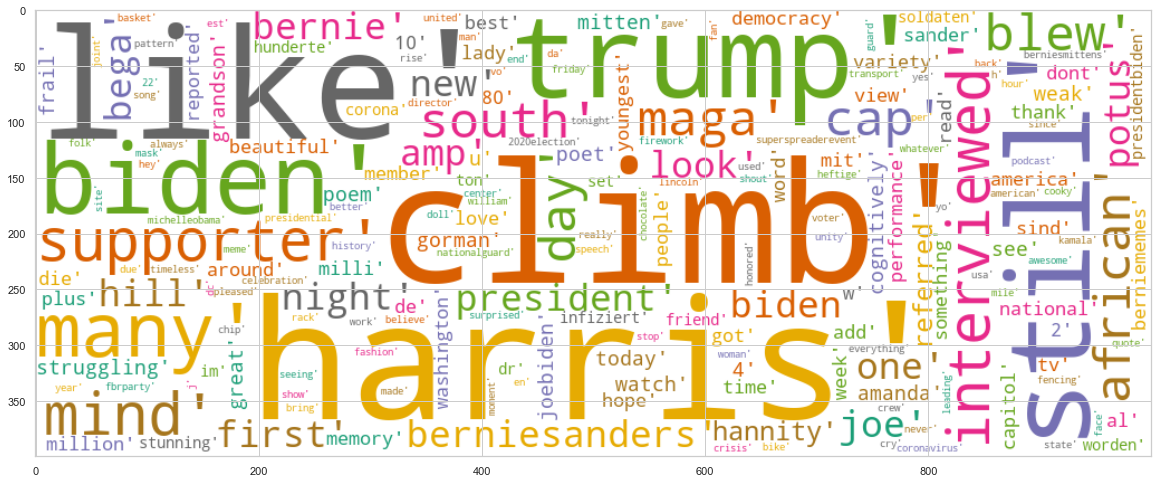

In [380]:
wc = WordCloud(background_color="white", colormap="Dark2", width = 1000, height = 400,
               max_font_size=150).generate(str(list(words_df['word'])))

fig, ax = plt.subplots(figsize=(20, 15))

ax.imshow(wc, interpolation='bilinear')

### Hashtags

In [428]:
hashtag_df = pd.DataFrame()
hashtag_df['word'] = list(dict(Counter(hashtag(tweets))).keys())
hashtag_df['count'] = list(dict(Counter(hashtag(tweets))).values())
hashtag_df = hashtag_df.sort_values(by=['count'], ascending = False)

,word,count
5,JoeBiden,24
28,BernieSanders,24
15,berniesanders,21
332,Washington,16
333,Corona,16
...,...,...
238,coffee,1
237,RussiaProtests…,1
236,Sunrise,1
235,nantucketisland…,1


In [432]:
p = figure(x_range=list(hashtag_df.head(20)['word']), plot_height=350)

p.vbar(x =hashtag_df['word'].head(20), top=hashtag_df['count'].head(20), \
       width=0.9, line_color='white', \
       fill_color = random.sample(Plasma256,20))

p.xaxis.major_label_orientation = "vertical"
p.add_tools(HoverTool())
p.y_range=Range1d(0, 25)
p.title.text="Word Counts"
p.title.text_font_size = "25px"
p.title.align = 'center'
p.xaxis.axis_label = 'Word'
p.yaxis.axis_label = 'Count'

show(p)